Import library

In [1]:
# Importing a library for work
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as ctb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt
import seaborn as sns

import eli5
import time

In [2]:
# List of models that will be tested on the dataset
models = [
	DecisionTreeClassifier(max_depth=7),
	RandomForestClassifier(max_depth=7, n_estimators = 100, random_state=0),
	ExtraTreesClassifier(max_depth=7, n_estimators = 100, random_state=0),
	lgbm.LGBMClassifier(max_depth=7, n_estimators = 100, random_state=0, learning_rate=0.3),
	xgb.XGBClassifier(max_depth=7, n_estimators = 100, random_state=0, learning_rate=0.3),
	ctb.CatBoostClassifier(max_depth=7, n_estimators = 100, random_state=0, learning_rate=0.3, verbose=False)
]

Dataset loading. Primary Analysis

In [3]:
# Loading training and test data
df_train = pd.read_csv('datasets/my_train.csv')
df_test = pd.read_csv('datasets/my_test.csv')

In [4]:
# Function for primary selection of parameters
def get_feats(df, black_list=set(['id', 'churn_probability'])):
	feats = [x for x in df.select_dtypes(np.number).columns if x not in black_list]
	return feats

# Getting all the features
feats = get_feats(df_train)

In [5]:
# Feature to view useful features
def show_features_func(model, feats):
	model.fit(df_train[feats].fillna(-1).values, 
				 df_train['churn_probability'].values)
	return eli5.show_weights(model, feature_names=feats, top=len(feats))

# Let's derive the basic useful features for the model (LGBMClassifier)
show_features_func(models[3], feats)

Weight,Feature
0.3791,total_ic_mou_8
0.0823,loc_ic_mou_8
0.0328,roam_og_mou_8
0.0236,last_day_rch_amt_8
0.0214,fb_user_8
0.0202,onnet_mou_8
0.0178,loc_ic_t2m_mou_8
0.0133,aon
0.0105,total_rech_num_7
0.0092,total_ic_mou_7


In [6]:
# Dataset form - 170 features, 35000 observations
df_train.shape, df_test.shape

((34999, 171), (35000, 170))

In [6]:
# You can reduce the size of the dataset for better performance
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34999 entries, 0 to 34998
Columns: 171 entries, id to churn_probability
dtypes: float64(135), int64(30), object(6)
memory usage: 45.7+ MB


In [7]:
# Function to compress data size. After analysis, we will use this function
def compress_size(df):
	df_copy = df.copy()
	columns = df_copy.select_dtypes(np.number).columns
	for col in columns:
		if df_copy[col].dtypes == 'int64' and col != 'id':
			df_copy[col] = df_copy[col].astype('int16')
		elif df_copy[col].dtypes == 'float64' and col != 'id':
			df_copy[col] = df_copy[col].astype('float32')
	
	return df_copy

In [8]:
# Descriptive statistics of all numerical features
df_train.describe()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,34999.000000,34633.0,34633.0,34633.0,34999.0,34999.0,34999.0,34999.000000,34999.000000,34999.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.0,33658.0,33141.0,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,34999.000000,34999.000000,34999.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.0,33658.0,33141.0,33614.000000,33658.000000,33141.000000,34999.000000,34999.000000,34999.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,33614.000000,33658.000000,33141.000000,34999.000000,34999.000000,34999.000000,34999.000000,34999.000000,34999.000000,34999.000000,34999.000000,34999.000000,34999.000000,34999.000000,34999.000000,8767.000000,9026.000000,9274.000000,8767.000000,9026.000000,9274.000000,8767.000000,9026.000000,9274.000000,8767.000000,9026.000000,9274.000000,8767.00

In [9]:
# Distribution of the target variable. The purpose of the prediction is the outflow of customers. This class - 1
# The data is unbalanced. This fact must be taken into account when training the model.
df_train['churn_probability'].value_counts()

0    31433
1     3566
Name: churn_probability, dtype: int64

In [10]:
# Let's see how many missing values are in the dataset
def check_missing(df):
	for column in df.columns:
		missing = column, df[column].isnull().sum()
		if missing[1] == 0: continue
		print(missing)

# It can be seen that there are a lot of features with missing values
# In the future, fill in empty values by (-1)
check_missing(df_train)

('loc_og_t2o_mou', 366)
('std_og_t2o_mou', 366)
('loc_ic_t2o_mou', 366)
('onnet_mou_6', 1385)
('onnet_mou_7', 1341)
('onnet_mou_8', 1858)
('offnet_mou_6', 1385)
('offnet_mou_7', 1341)
('offnet_mou_8', 1858)
('roam_ic_mou_6', 1385)
('roam_ic_mou_7', 1341)
('roam_ic_mou_8', 1858)
('roam_og_mou_6', 1385)
('roam_og_mou_7', 1341)
('roam_og_mou_8', 1858)
('loc_og_t2t_mou_6', 1385)
('loc_og_t2t_mou_7', 1341)
('loc_og_t2t_mou_8', 1858)
('loc_og_t2m_mou_6', 1385)
('loc_og_t2m_mou_7', 1341)
('loc_og_t2m_mou_8', 1858)
('loc_og_t2f_mou_6', 1385)
('loc_og_t2f_mou_7', 1341)
('loc_og_t2f_mou_8', 1858)
('loc_og_t2c_mou_6', 1385)
('loc_og_t2c_mou_7', 1341)
('loc_og_t2c_mou_8', 1858)
('loc_og_mou_6', 1385)
('loc_og_mou_7', 1341)
('loc_og_mou_8', 1858)
('std_og_t2t_mou_6', 1385)
('std_og_t2t_mou_7', 1341)
('std_og_t2t_mou_8', 1858)
('std_og_t2m_mou_6', 1385)
('std_og_t2m_mou_7', 1341)
('std_og_t2m_mou_8', 1858)
('std_og_t2f_mou_6', 1385)
('std_og_t2f_mou_7', 1341)
('std_og_t2f_mou_8', 1858)
('std_og_t2c_

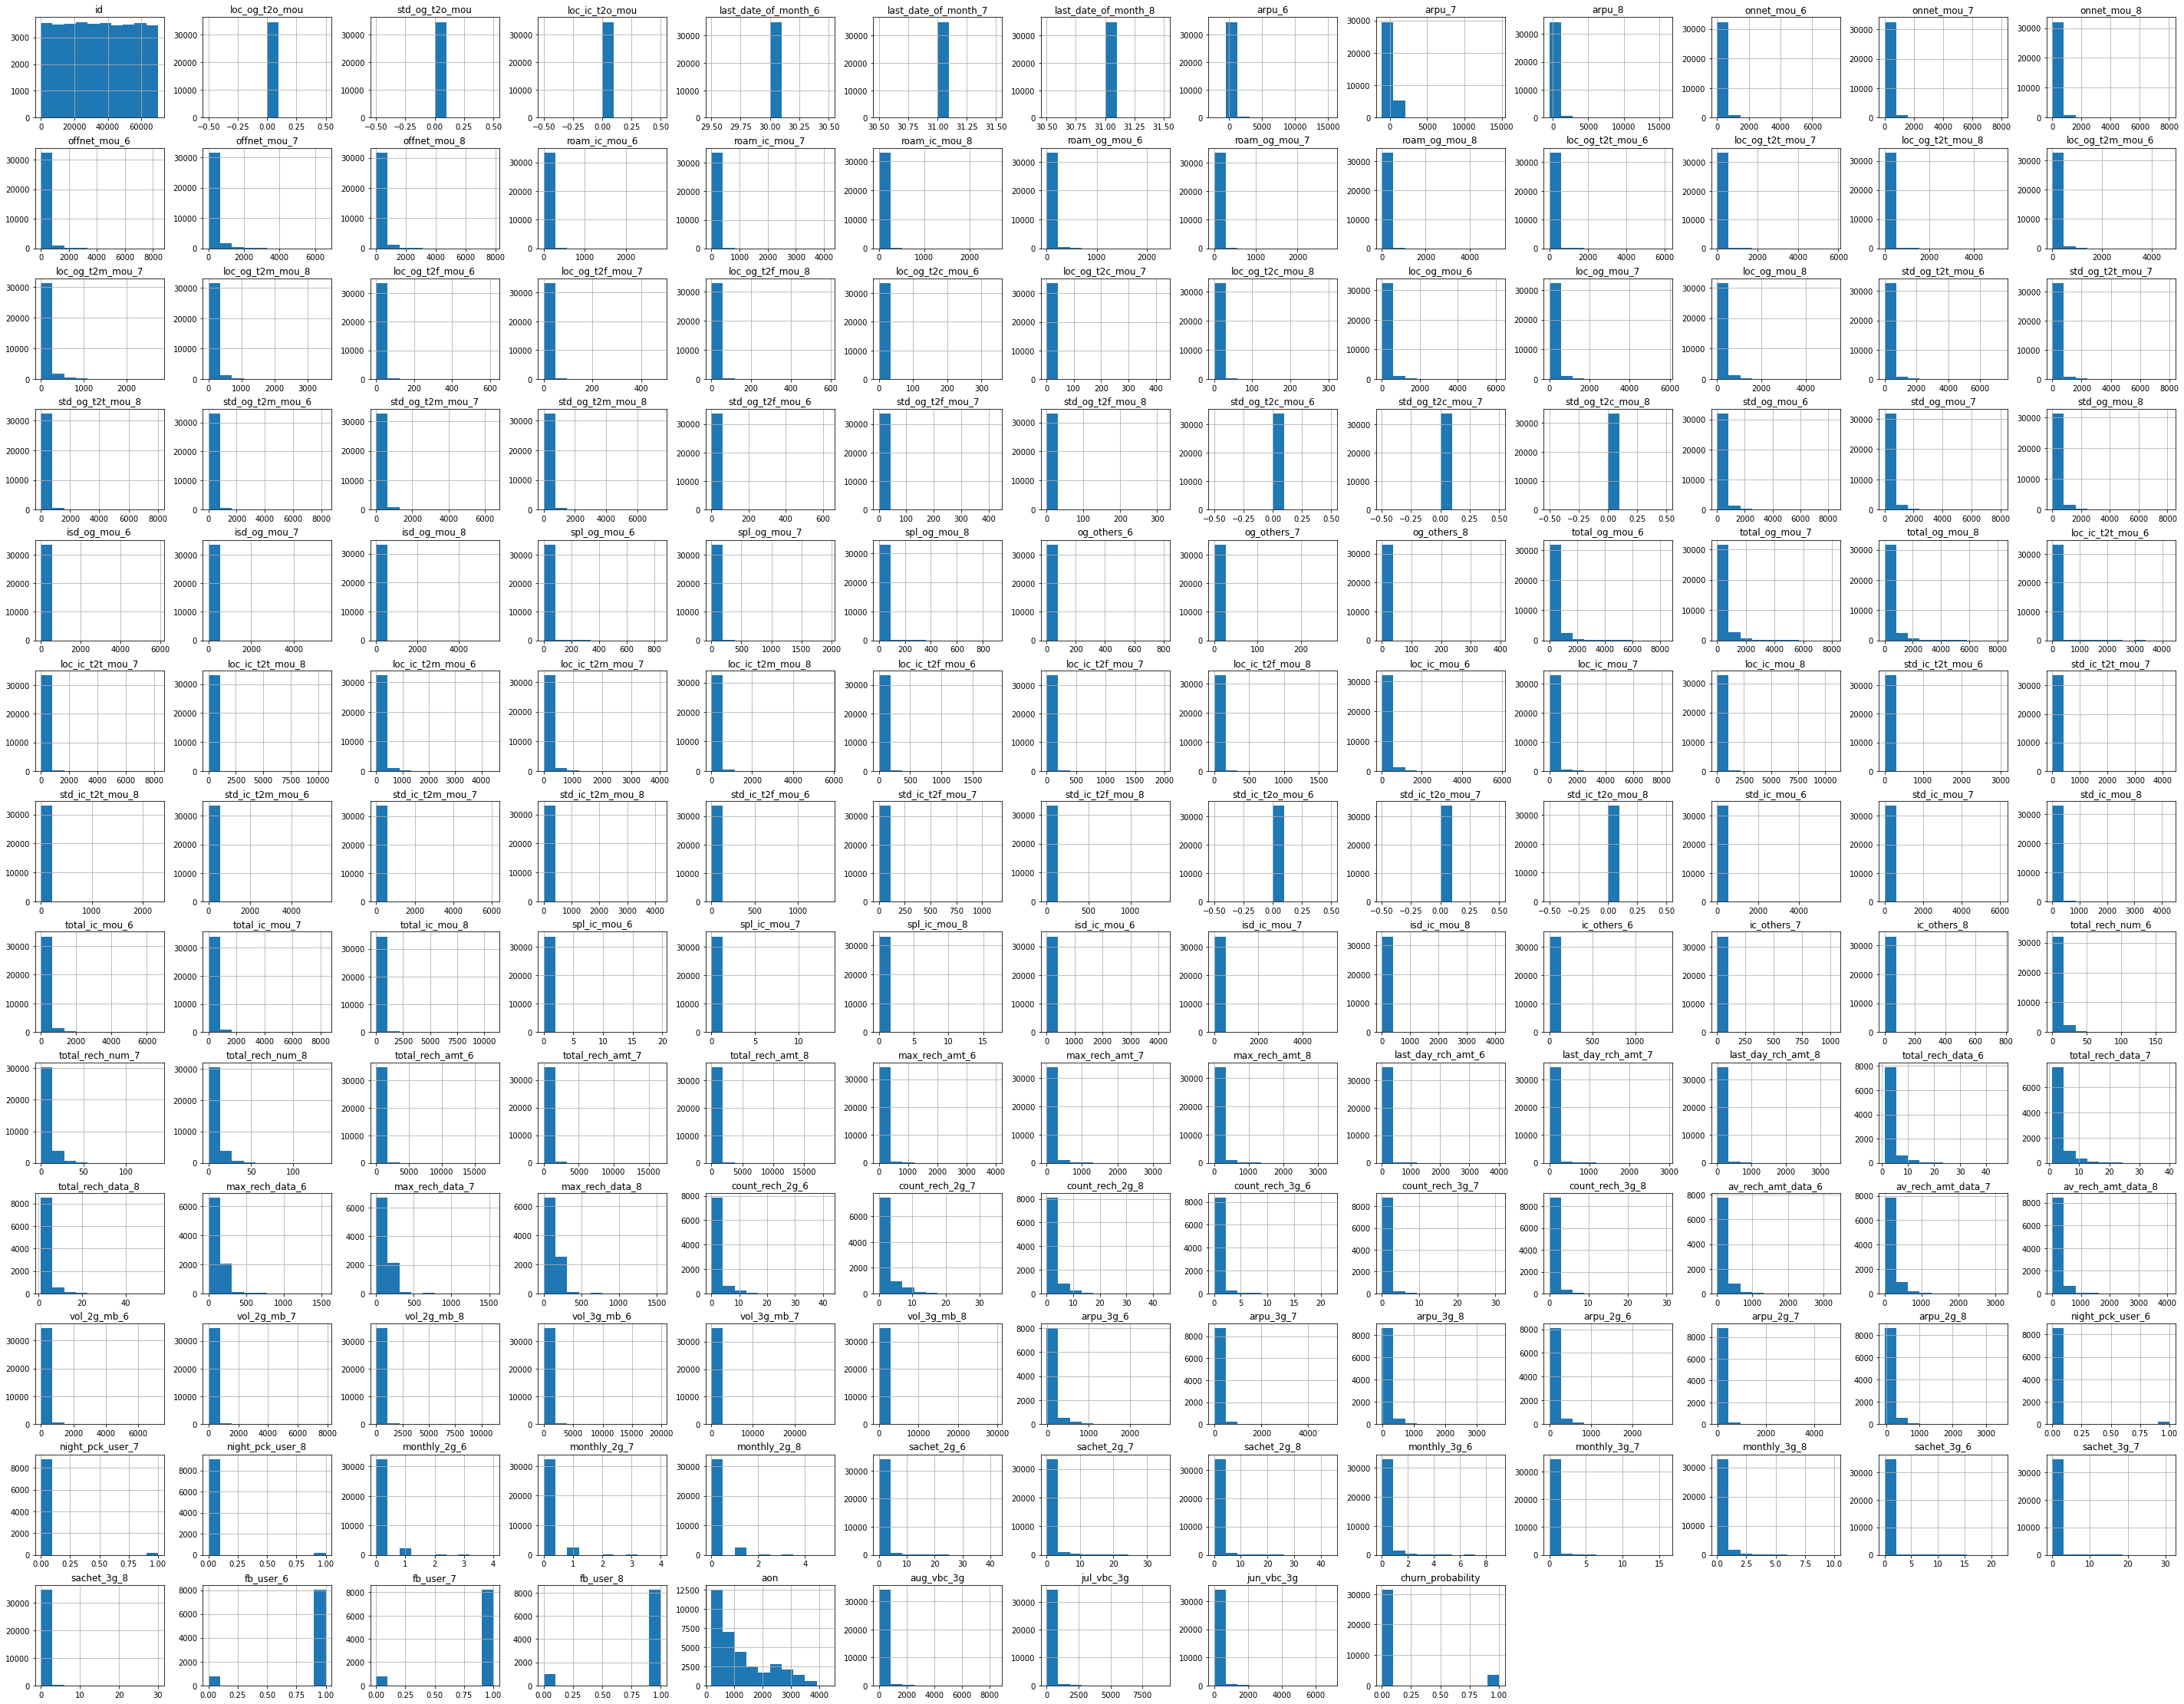

In [11]:
# Let's look at frequency histograms
plt.rcParams['figure.figsize']=(50, 40)
df_train.hist();

In [12]:
# Let's replace the negative values in the columns arpu_6,7,8 because the average income cannot be negative

# TRAIN
df_train['arpu_6'] = df_train['arpu_6'].abs()
df_train['arpu_7'] = df_train['arpu_7'].abs()
df_train['arpu_8'] = df_train['arpu_8'].abs()
df_train['arpu_3g_6'] = df_train['arpu_3g_6'].abs()
df_train['arpu_3g_7'] = df_train['arpu_3g_7'].abs()
df_train['arpu_3g_8'] = df_train['arpu_3g_8'].abs()
df_train['arpu_2g_6'] = df_train['arpu_2g_6'].abs()
df_train['arpu_2g_7'] = df_train['arpu_2g_7'].abs()
df_train['arpu_2g_8'] = df_train['arpu_2g_8'].abs()

# TEST
df_test['arpu_6'] = df_test['arpu_6'].abs()
df_test['arpu_7'] = df_test['arpu_7'].abs()
df_test['arpu_8'] = df_test['arpu_8'].abs()
df_test['arpu_3g_6'] = df_test['arpu_3g_6'].abs()
df_test['arpu_3g_7'] = df_test['arpu_3g_7'].abs()
df_test['arpu_3g_8'] = df_test['arpu_3g_8'].abs()
df_test['arpu_2g_6'] = df_test['arpu_2g_6'].abs()
df_test['arpu_2g_7'] = df_test['arpu_2g_7'].abs()
df_test['arpu_2g_8'] = df_test['arpu_2g_8'].abs()

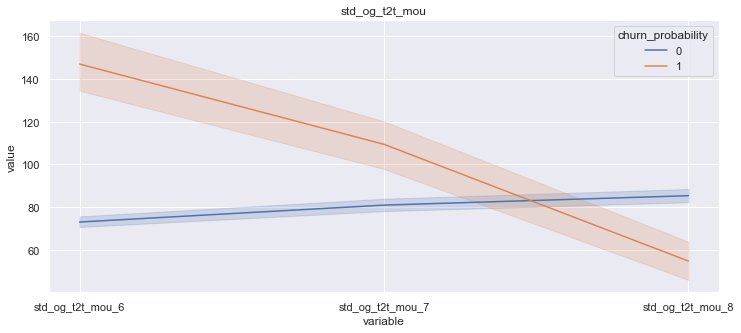

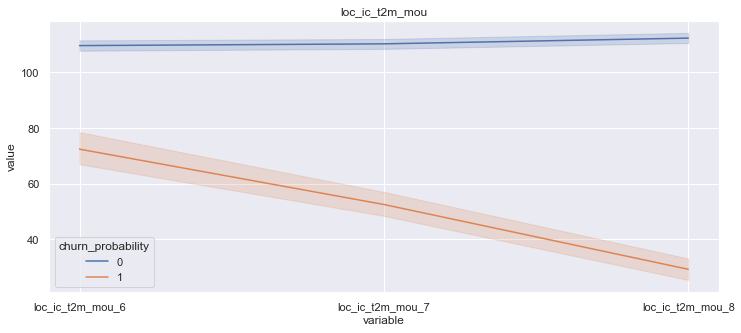

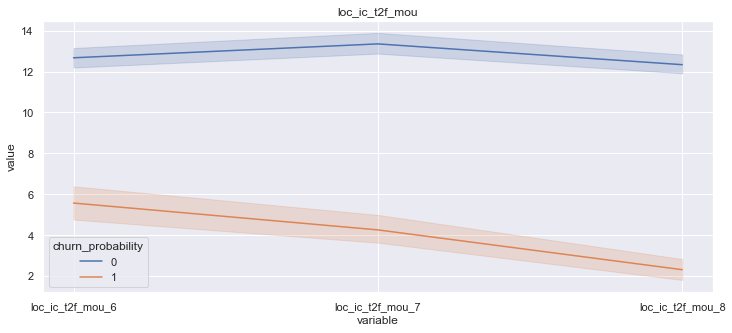

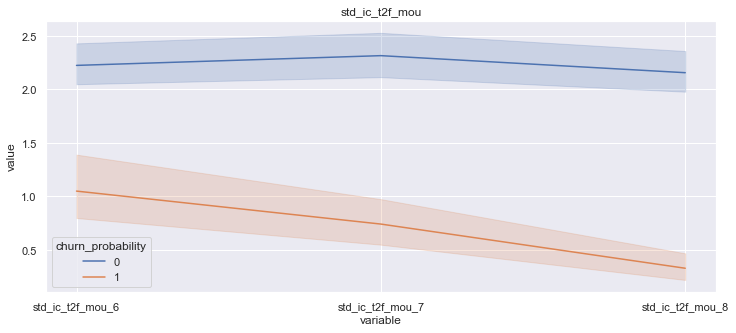

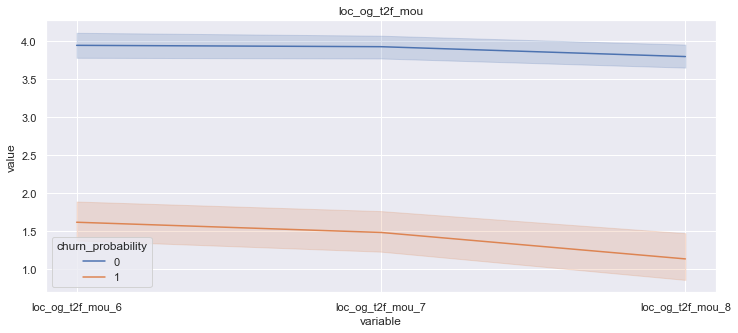

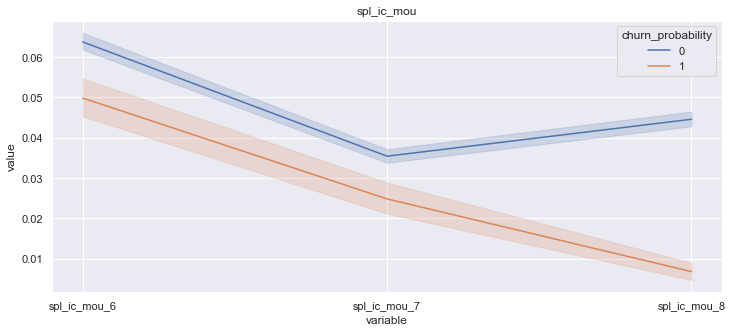

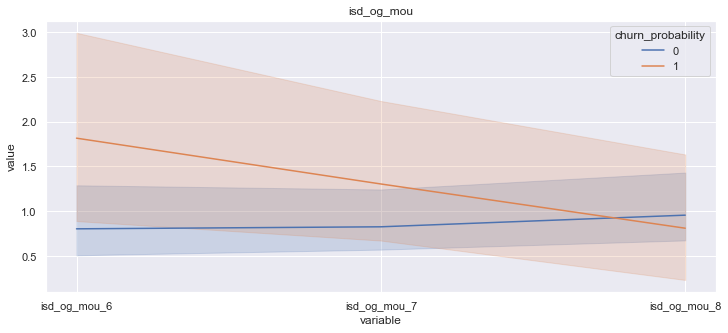

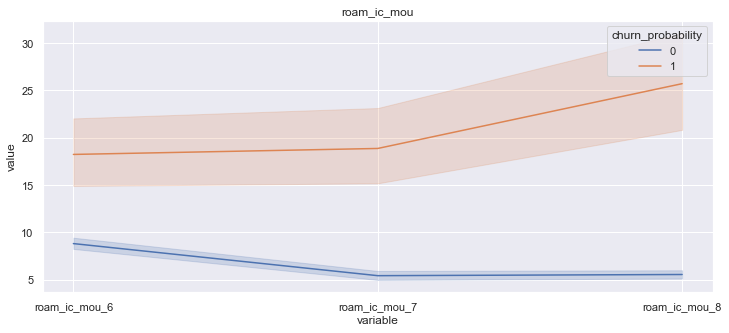

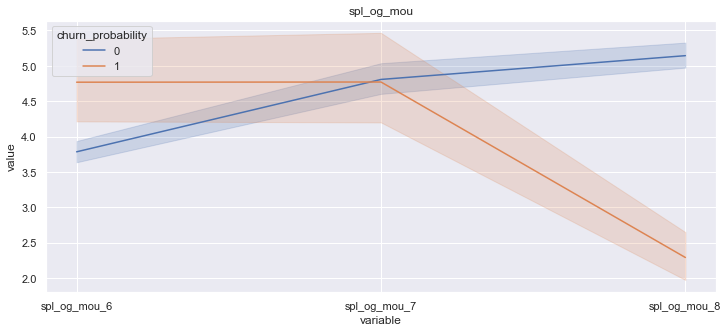

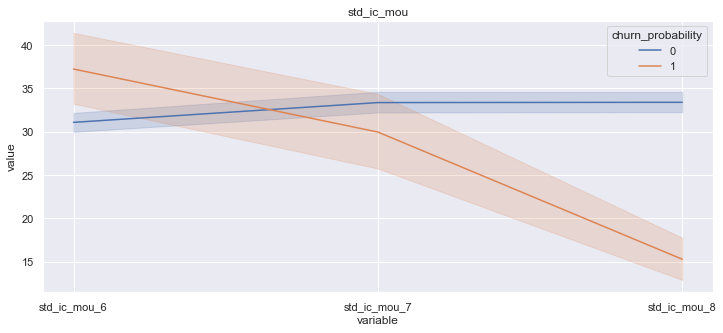

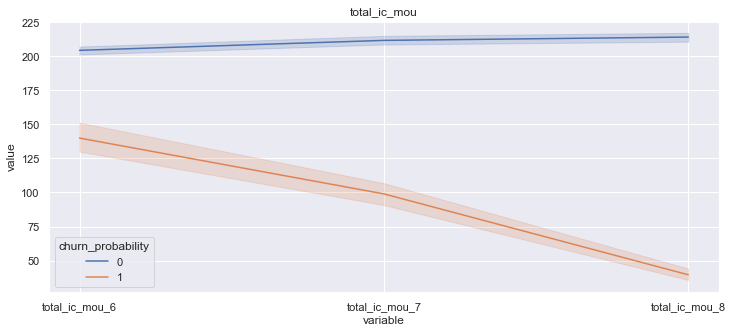

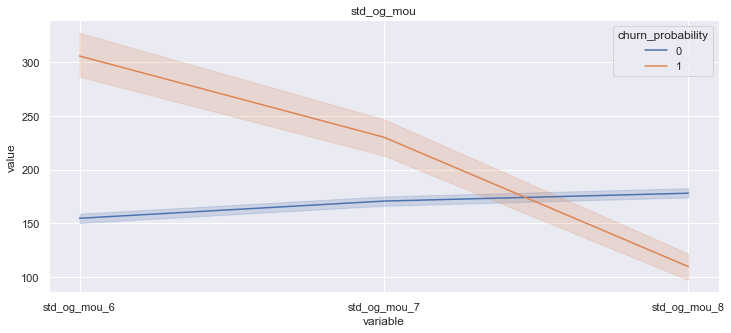

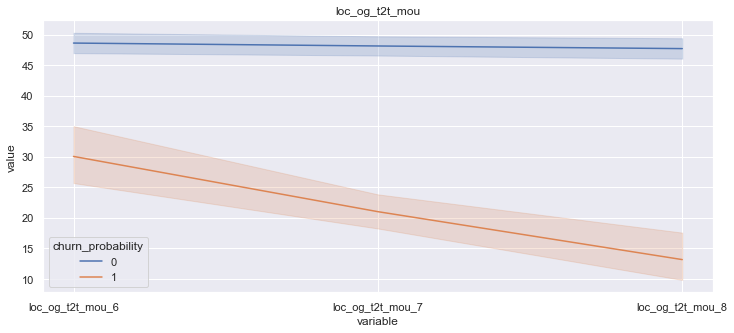

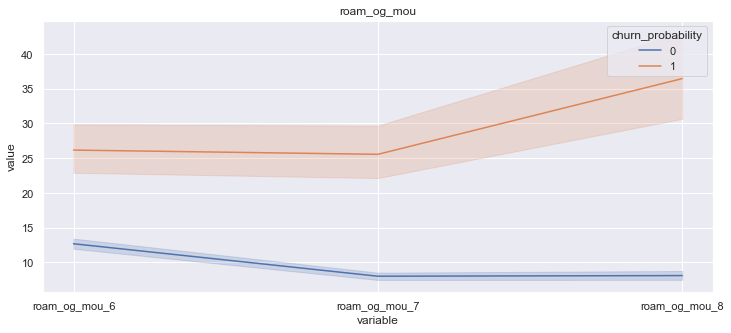

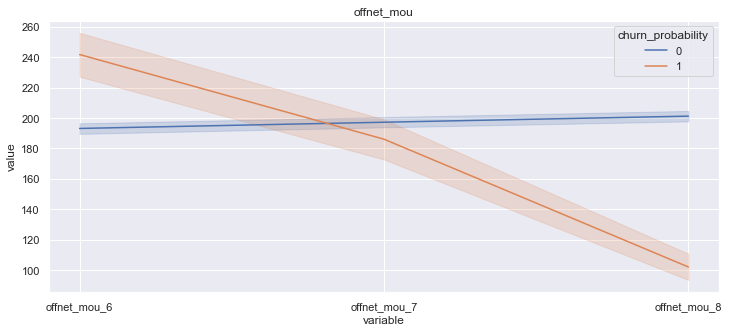

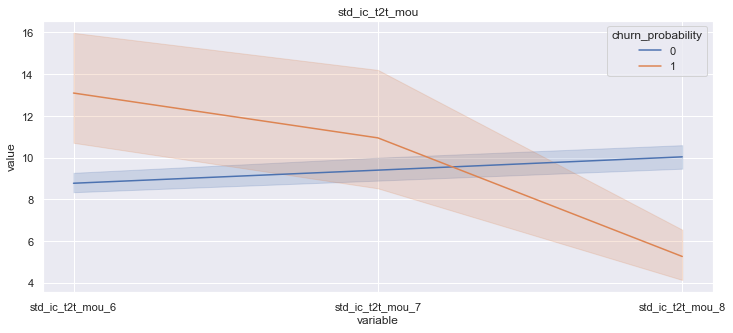

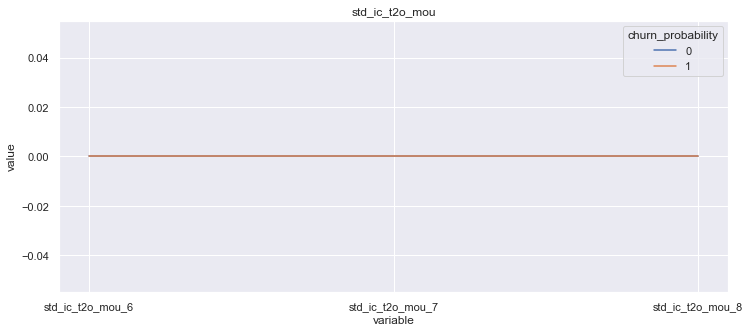

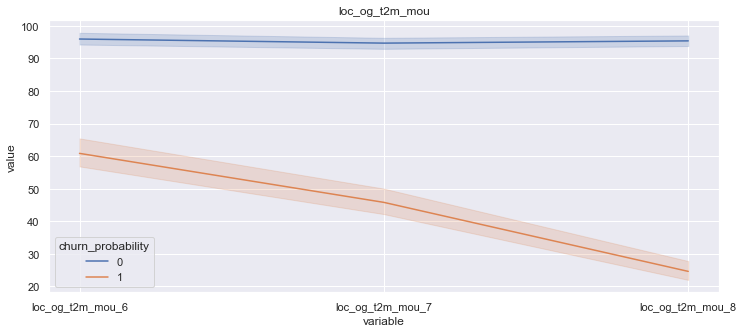

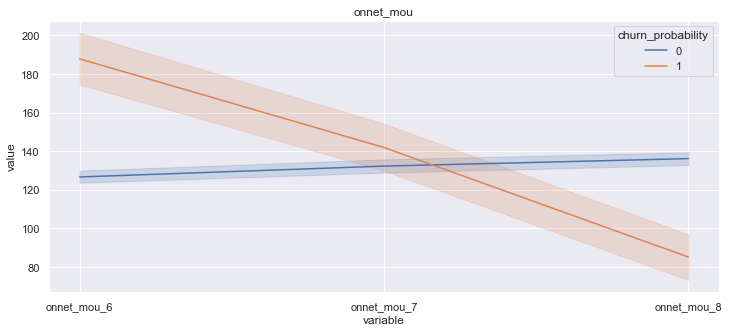

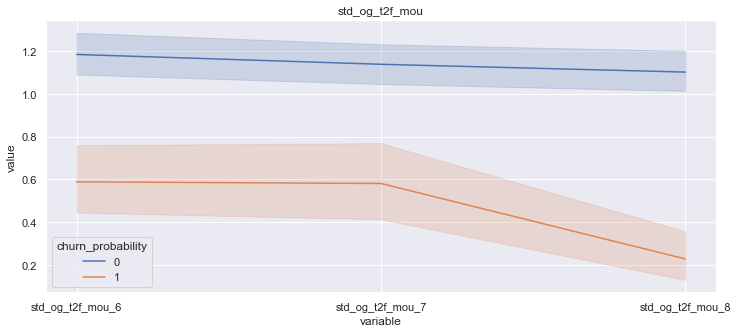

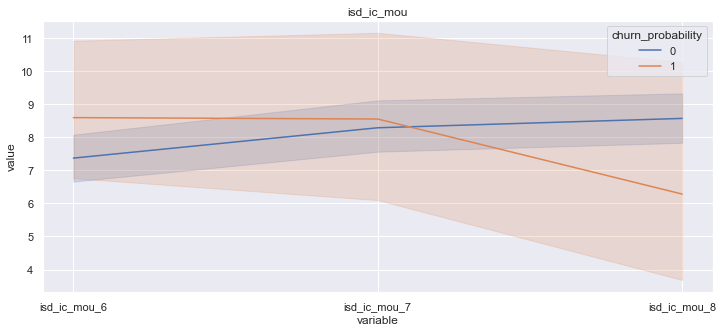

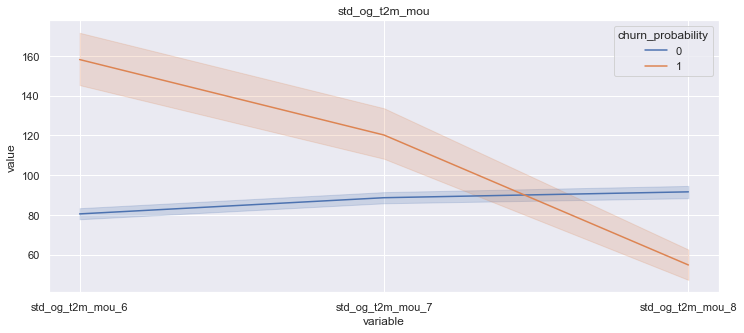

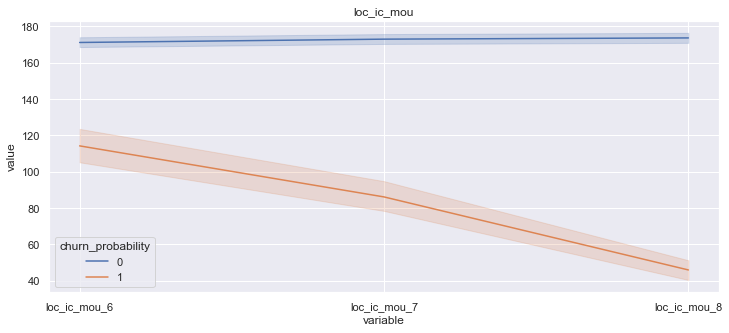

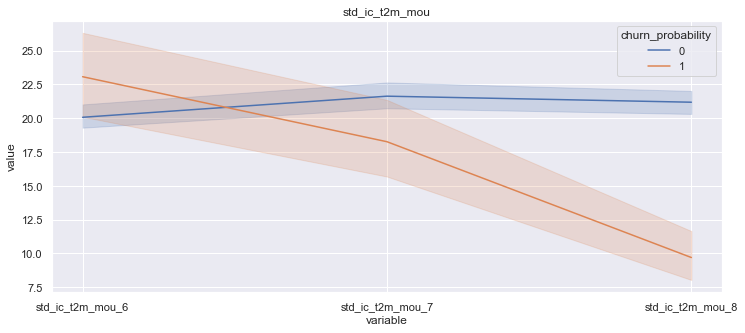

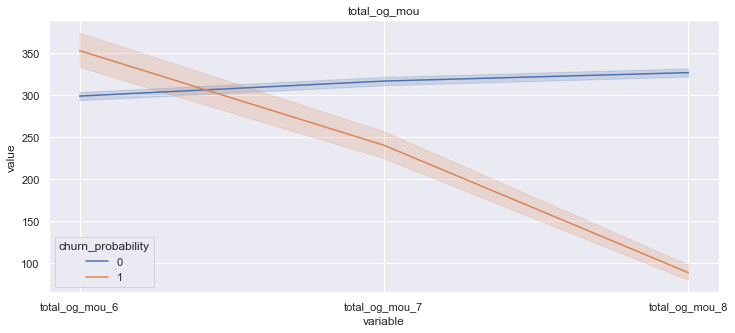

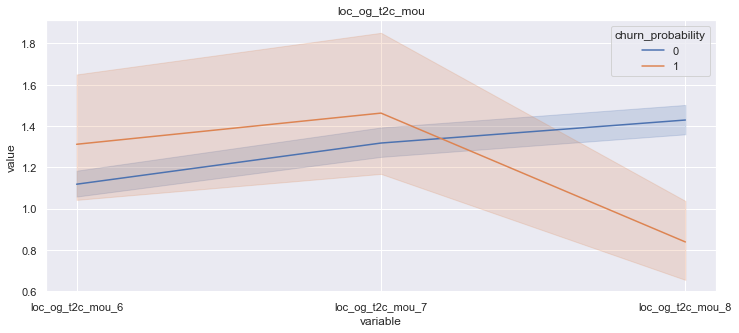

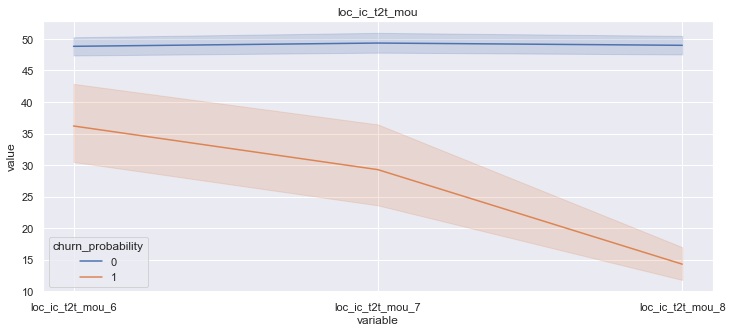

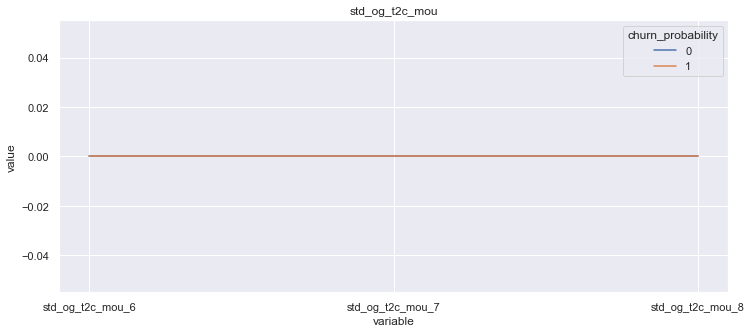

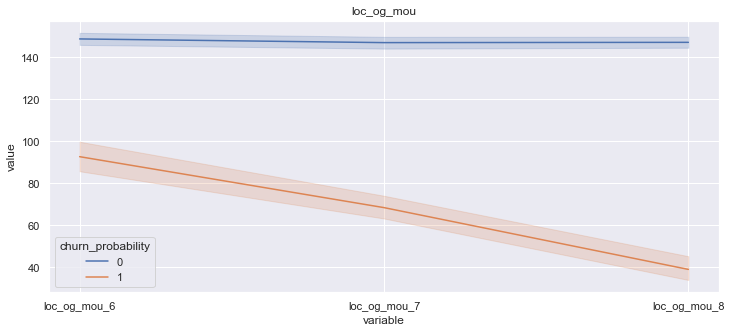

In [13]:
# Let's look at the signs combined by months (only 3 months of observations)
sns.set(rc={'figure.figsize':(12,5)})
metrics = {'_'.join(x.split('_')[:-1]) for x in df_train.columns if 'mou_6' in x}

for metric in metrics:
	feats = ['{}_{}'.format(metric, x) for x in [6, 7, 8]]
	df_sel = df_train[feats + ['churn_probability']]
	df_melt = pd.melt(df_sel, id_vars=['churn_probability'])
	sns.lineplot(x='variable', y='value', hue='churn_probability', data=df_melt)
	plt.title(metric)
	plt.show();

# It can be seen that most of the graphs show that the potential exit of customers is associated with the termination of the use of the service.

Feature selection

In [14]:
# Selection of useful features based on the show_features_func function
feats_sff = ["total_ic_mou_6", "total_ic_mou_8", "av_rech_amt_data_6", "av_rech_amt_data_8", "roam_og_mou_6", "roam_og_mou_7", "roam_og_mou_8","std_og_t2c_mou_8", "last_day_rch_amt_6", "last_day_rch_amt_7", "last_day_rch_amt_8", "loc_ic_mou_7", "loc_ic_mou_8", "loc_ic_t2m_mou_6", "loc_ic_t2m_mou_7", "loc_ic_t2m_mou_8", "total_rech_amt_8", "std_og_mou_6", "std_og_mou_7", "std_og_mou_8", "loc_og_t2f_mou_7","loc_og_t2f_mou_8", "arpu_7", "arpu_8", "total_og_mou_8", "aon", "max_rech_amt_6", "max_rech_amt_8", "total_rech_num_6", "total_rech_num_7", "total_rech_num_8", "loc_ic_t2f_mou_6", "loc_ic_t2f_mou_7", "roam_ic_mou_6", "roam_ic_mou_7", "roam_ic_mou_8", "isd_og_mou_8", "arpu_3g_6", "arpu_3g_7", "std_og_t2m_mou_7", "onnet_mou_6", "onnet_mou_7", "onnet_mou_8", "loc_ic_t2t_mou_6", "loc_ic_t2t_mou_8", "isd_ic_mou_6", "isd_ic_mou_8","loc_og_t2t_mou_7", "loc_og_t2t_mou_8", "fb_user_8", "std_og_t2f_mou_7", "std_og_t2o_mou", "std_ic_t2m_mou_6", "std_ic_t2m_mou_7", "std_ic_t2m_mou_8", "max_rech_data_7", "arpu_2g_6", "monthly_2g_7", "monthly_2g_8", "spl_ic_mou_7", "spl_ic_mou_8", "aug_vbc_3g", "std_ic_t2t_mou_6", "std_ic_t2t_mou_7", "loc_og_t2m_mou_6", "loc_og_t2m_mou_8", "spl_og_mou_7", "offnet_mou_6", "offnet_mou_7", "offnet_mou_8", "count_rech_2g_6", "vol_3g_mb_6", "vol_3g_mb_8", "loc_og_t2c_mou_6", "loc_og_t2c_mou_7", "ic_others_6", "loc_og_mou_8", "night_pck_user_8"]

In [15]:
# Features based on sum of features mou
# TRAIN
mou_6_cols = [col for col in df_train.columns if '_mou_6' in col]
mou_7_cols = [col for col in df_train.columns if '_mou_7' in col]
mou_8_cols = [col for col in df_train.columns if '_mou_8' in col]
df_train['mou_6_sum'] = df_train[mou_6_cols].sum(axis=1)
df_train['mou_7_sum'] = df_train[mou_7_cols].sum(axis=1)
df_train['mou_8_sum'] = df_train[mou_8_cols].sum(axis=1)

# TEST
mou_6_cols = [col for col in df_test.columns if '_mou_6' in col]
mou_7_cols = [col for col in df_test.columns if '_mou_7' in col]
mou_8_cols = [col for col in df_test.columns if '_mou_8' in col]
df_test['mou_6_sum'] = df_test[mou_6_cols].sum(axis=1)
df_test['mou_7_sum'] = df_test[mou_7_cols].sum(axis=1)
df_test['mou_8_sum'] = df_test[mou_8_cols].sum(axis=1)

# Ready features
feats_mou_sum = ['mou_6_sum', 'mou_7_sum','mou_8_sum']

In [16]:
# rech-based features
total_rech_num_cols = [col for col in df_train.columns if 'total_rech_num' in col]
max_rech_amt_cols = [col for col in df_train.columns if 'max_rech_amt' in col]
total_rech_data_cols = [col for col in df_train.columns if 'total_rech_data' in col]
max_rech_data_cols = [col for col in df_train.columns if 'max_rech_data' in col]
count_rech_2g_cols = [col for col in df_train.columns if 'count_rech_2g' in col]
count_rech_3g_cols = [col for col in df_train.columns if 'count_rech_3g' in col]
av_rech_amt_data_cols = [col for col in df_train.columns if 'av_rech_amt_data' in col]

# TRAIN
df_train['total_rech_num_sum']=df_train[total_rech_num_cols].sum(axis=1)
df_train['max_rech_amt_sum']=df_train[max_rech_amt_cols].sum(axis=1)
df_train['total_rech_data_sum']=df_train[total_rech_data_cols].sum(axis=1)
df_train['max_rech_data_sum']=df_train[max_rech_data_cols].sum(axis=1)
df_train['count_rech_2g_sum']=df_train[count_rech_2g_cols].sum(axis=1)
df_train['count_rech_3g_sum']=df_train[count_rech_3g_cols].sum(axis=1)
df_train['av_rech_amt_data_sum']=df_train[av_rech_amt_data_cols].sum(axis=1)

# TEST
total_rech_num_cols = [col for col in df_test.columns if 'total_rech_num' in col]
max_rech_amt_cols = [col for col in df_test.columns if 'max_rech_amt' in col]
total_rech_data_cols = [col for col in df_test.columns if 'total_rech_data' in col]
max_rech_data_cols = [col for col in df_test.columns if 'max_rech_data' in col]
count_rech_2g_cols = [col for col in df_test.columns if 'count_rech_2g' in col]
count_rech_3g_cols = [col for col in df_test.columns if 'count_rech_3g' in col]
av_rech_amt_data_cols = [col for col in df_test.columns if 'av_rech_amt_data' in col]

# Ready features
df_test['total_rech_num_sum']=df_test[total_rech_num_cols].sum(axis=1)
df_test['max_rech_amt_sum']=df_test[max_rech_amt_cols].sum(axis=1)
df_test['total_rech_data_sum']=df_test[total_rech_data_cols].sum(axis=1)
df_test['max_rech_data_sum']=df_test[max_rech_data_cols].sum(axis=1)
df_test['count_rech_2g_sum']=df_test[count_rech_2g_cols].sum(axis=1)
df_test['count_rech_3g_sum']=df_test[count_rech_3g_cols].sum(axis=1)
df_test['av_rech_amt_data_sum']=df_test[av_rech_amt_data_cols].sum(axis=1)

feats_rech_sum = ['total_rech_num_sum','max_rech_amt_sum', 'total_rech_data_sum','max_rech_data_sum','count_rech_2g_sum','count_rech_3g_sum', 'av_rech_amt_data_sum']

In [17]:
# Final features
feats_all = feats_sff + feats_mou_sum + feats_rech_sum

In [18]:
# Let's use the function of compression of the sizes of observations
df_train = compress_size(df_train)
df_test = compress_size(df_test)

In [19]:
# Reduced the size by 2 times
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34999 entries, 0 to 34998
Columns: 181 entries, id to av_rech_amt_data_sum
dtypes: float32(143), int16(31), int64(1), object(6)
memory usage: 23.0+ MB


Model Training

In [20]:
# Divide by X, y, features - feats_all
X = df_train[feats_all].fillna(-1).values
y = df_train['churn_probability'].values
X_t = df_test[feats_all].fillna(-1).values

In [21]:
# The main function for training the model
def my_model(models, X, y, X_t, feats):

	# Use cross validation - 3 times
	cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
	
	# Information for creating a model report
	columns_describe = ['Classifier', 'Fbeta_score_mean', 'Std_mean', 'Duration_sec']	
	data_describe = []		

	# Running the learning model
	for model in models:

		# Run time to check the duration of an operation
		start_time = time.time()
		model_name = (str(model.__repr__).split("of")[-1].strip().split("(")[0].split(" ")[0].replace("classifier",""))

		scores = []
		proba_values = []
		for train_idx, test_idx in cv.split(X, y):
			X_train, X_test = X[train_idx], X[test_idx]
			y_train, y_test = y[train_idx], y[test_idx]

			model.fit(X_train, y_train)

			# TRAIN
			y_proba = model.predict_proba(X_test)[:, 1]
			y_pred_proba = (y_proba > 0.2).astype('int')
			score_fbeta = fbeta_score(y_test, y_pred_proba, beta=1.5)
			scores.append(score_fbeta)

			# TEST
			y_proba_test = model.predict_proba(X_t)[:, 1]
			proba_values.append(y_proba_test)
		
		y_pred_test = (np.average(proba_values, axis=0) > 0.2).astype('int')		# save for test
		
		'''To save results in csv format'''
		df_test['churn_probability'] = y_pred_test
		df_test[['id', 'churn_probability']].to_csv('output/{}_result.csv'.format(model_name), index=False)
		end_time = time.time()

		data_describe.append([model_name, round(np.mean(scores), 4), round(np.std(scores), 4), round((end_time - start_time), 4)])

	# creating Dataframe - report
	df_describe_score = pd.DataFrame(columns=columns_describe, data=data_describe)
	return df_describe_score

In [22]:
# Checking the performance of the model. Report Output
my_model(models, X, y, X_t, feats)

,Classifier,Fbeta_score_mean,Std_mean,Duration_sec
0,DecisionTreeClassifier,0.6810,0.0084,10.2692
1,RandomForestClassifier,0.6881,0.0051,65.8578
2,ExtraTreesClassifier,0.4895,0.0069,27.3437
3,LGBMClassifier,0.6950,0.0092,14.1761
4,XGBClassifier,0.6959,0.0068,116.3406
5,CatBoostClassifier,0.7055,0.0056,40.7288


In [23]:
# Checking the final predictions
# The best model with selected parameters - CatBoostClassifier
dff = pd.read_csv('output/CatBoostClassifier_result.csv')
dff

,id,churn_probability
0,0,0
1,1,0
2,2,0
3,4,0
4,5,1
...,...,...
34995,69990,0
34996,69991,1
34997,69992,0
34998,69995,1
